In [1]:
import os
import datetime
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from solver.processing import read_dataset

In [2]:
# define features to impute
features_impute = [
    'P_avg',
    'Ws_avg',
    'Ot_avg',
    'Wa_avg',
    'Ya_avg',
    'Ba_avg',
    'tempC',
    'precipMM',
    'humidity',
    'cloudcover',
    'windspeedKmph',
    'windspeedKmph_scaled',
    'tempC_scaled',
    'Day sin',
    'Day cos',
    'Year sin',
    'Year cos'
]

In [3]:
TURBINE_ID = 'R80711'
DATA_DIR = '../datasets/after_feature_engineering'

In [4]:
# define datasets
data_link = os.path.join(DATA_DIR, 'turbine_{}.csv'.format(TURBINE_ID))
# read datasets
dataset = read_dataset(data_link)

In [5]:
def drop_duplicates(df):
    print("Number of duplicates: {}".format(len(df.index[df.index.duplicated()].unique())))
    return df[~df.index.duplicated(keep='first')]

In [6]:
# Drop duplicated timesteps
dataset = dataset[features_impute+['Date_time']].copy()
dataset = drop_duplicates(dataset)

Number of duplicates: 0


In [7]:
# Check how many missing data exists
missing_idx = np.array(dataset[dataset.isnull().any(axis=1)].index)
print("Missing data percent: {}%".format(np.round(missing_idx.shape[0]/dataset.shape[0]*100, 5)))

Missing data percent: 3.80613%


In [8]:
missing_mask = dataset.index.isin(missing_idx)
dataset_only_missing = dataset.loc[missing_mask]

In [9]:
# Find runs of consecutive numbers using groupby.  The key to the solution
# is differencing with a range so that consecutive numbers all appear in
# same group.

data_split = []
count = []
indices = []

data = dataset_only_missing.index
for k, g in groupby(enumerate(data), lambda i_x: i_x[0] - i_x[1]):
    group = list(map(itemgetter(1), g))
    min_el, max_el, size = min(group), max(group), len(group)
    date_1 = dataset_only_missing.loc[min_el, 'Date_time'].strftime("%Y-%m-%d %H:%M")
    data_2 = dataset_only_missing.loc[max_el, 'Date_time'].strftime("%Y-%m-%d %H:%M")
    data_split.append('{}, {}'.format(date_1, data_2))
    count.append(size)
    indices.append([min_el, max_el])

In [10]:
# Indices representing missing values
count = np.array(count)
indices = np.array(indices)
data_split = np.array(data_split)
indices_to_test = indices[count >= 1]
data_split_plot = data_split[count >= 1]
count_plot = count[count >= 1]

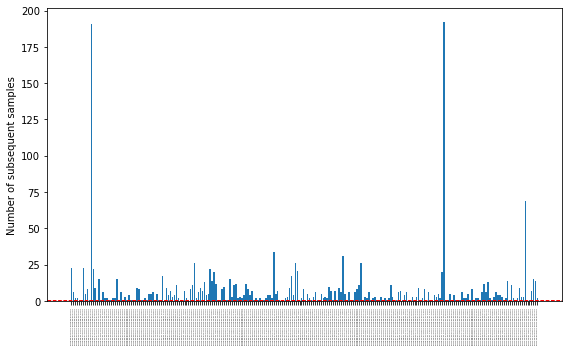

In [11]:
plt.figure(figsize=(8,5))
plt.bar(data_split_plot, count_plot)
plt.xticks(rotation='vertical', fontsize=2)
plt.ylabel("Number of subsequent samples")
plt.axhline(y=1, color='r', linestyle='--', linewidth=1)
plt.tight_layout()
#plt.savefig("non_missing_samples_len_1.pdf", dpi=450)
plt.show()

In [12]:
# define a number when interpolation process changes to different one
CHANGE_INTERPOLATION_NUM = 8

# create mask for two interpolation methodologies
linear_mask = np.zeros(dataset.shape[0]).astype(bool)
tree_mask = np.zeros(dataset.shape[0]).astype(bool)
for idx in indices_to_test:
    if idx[1] - idx[0] + 1 > CHANGE_INTERPOLATION_NUM:
        # do tree interpolation
        tree_mask[idx[0]:idx[1]+1] = True
    else:
        # do linear interpolation
        linear_mask[idx[0]:idx[1]+1] = True

In [13]:
# Perform linear interpolation for short sequences of missing values
dataset_cp = dataset.copy()
dataset_cp.loc[linear_mask, 'P_avg'] = dataset[['P_avg']].interpolate('linear')[linear_mask]
dataset_cp.loc[linear_mask, 'Ws_avg'] = dataset[['Ws_avg']].interpolate('linear')[linear_mask]
dataset_cp.loc[linear_mask, 'Ot_avg'] = dataset[['Ot_avg']].interpolate('linear')[linear_mask]
dataset_cp.loc[linear_mask, 'Wa_avg'] = dataset[['Wa_avg']].interpolate('linear')[linear_mask]
dataset_cp.loc[linear_mask, 'Ya_avg'] = dataset[['Ya_avg']].interpolate('linear')[linear_mask]
dataset_cp.loc[linear_mask, 'Ba_avg'] = dataset[['Ba_avg']].interpolate('linear')[linear_mask]

In [14]:
# Perform tree interpolation, column by column
# define columns to impute
columns = ['P_avg', 'Ws_avg', 'Ot_avg', 'Wa_avg', 'Ya_avg', 'Ba_avg']
dataset_cp2 = dataset_cp.copy()
minimums = dataset_cp2.min().values[:len(columns)]

#dataset_cp3 = dataset_cp2.copy()
for idx, (col, min_value) in tqdm(enumerate(zip(columns, minimums))):
    # define imputer for each column with different minimum values
    imputer = IterativeImputer(
        max_iter=10,
        initial_strategy='mean',
        min_value=min_value,
        estimator=ExtraTreesRegressor(n_estimators=100),
        verbose=1
    )

    dataset_cp22 = dataset_cp2.copy()
    columns_to_drop = columns.copy()
    # remove other numerical variables with nan to fit imputer for a single variable
    del columns_to_drop[idx]
    columns_to_drop.append('Date_time')
    dataset_cp22.drop(columns_to_drop, axis=1, inplace=True)
    # fit imputer
    print(dataset_cp22.columns)
    imputer.fit(dataset_cp22)
    imputed = imputer.transform(dataset_cp22)[:,0]
    dataset_cp2.iloc[:, idx] = imputed

0it [00:00, ?it/s]

Index(['P_avg', 'tempC', 'precipMM', 'humidity', 'cloudcover', 'windspeedKmph',
       'windspeedKmph_scaled', 'tempC_scaled', 'Day sin', 'Day cos',
       'Year sin', 'Year cos'],
      dtype='object')
[IterativeImputer] Completing matrix with shape (43824, 12)
[IterativeImputer] Change: 1202.1448792098536, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 257.1449467195922, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 167.30335931991226, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 317.65944602570517, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 219.77922563510936, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 214.4584548987906, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 170.98222494813638, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 245.59018445219363, scaled tolerance: 2.0501350166666668 
[IterativeImputer] Change: 175.68728238033623, scaled toler

/Users/macbook/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (43824, 12)


1it [20:33, 1233.67s/it]

Index(['Ws_avg', 'tempC', 'precipMM', 'humidity', 'cloudcover',
       'windspeedKmph', 'windspeedKmph_scaled', 'tempC_scaled', 'Day sin',
       'Day cos', 'Year sin', 'Year cos'],
      dtype='object')
[IterativeImputer] Completing matrix with shape (43824, 12)
[IterativeImputer] Change: 5.850503217620698, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7277500080000046, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9248599994399971, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.848749997166669, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.0573833465633342, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9909500115000043, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.857790037166664, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7337000119166648, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7760799939999998, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7091899968500011, scaled tolerance: 0.1 


/Users/macbook/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (43824, 12)


2it [40:35, 1214.79s/it]

Index(['Ot_avg', 'tempC', 'precipMM', 'humidity', 'cloudcover',
       'windspeedKmph', 'windspeedKmph_scaled', 'tempC_scaled', 'Day sin',
       'Day cos', 'Year sin', 'Year cos'],
      dtype='object')
[IterativeImputer] Completing matrix with shape (43824, 12)
[IterativeImputer] Change: 20.77883744458436, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.326768346416669, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.4017611111266666, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.2352166580000006, scaled tolerance: 0.1 
[IterativeImputer] Change: 2.0422516775000013, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.5303833367499937, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.0831052071047642, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9992366399999923, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.3324333155000065, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.298241694833333, scaled tolerance: 0.1 
[IterativeImputer] Completing matrix wi

/Users/macbook/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
3it [58:04, 1138.99s/it]

Index(['Wa_avg', 'tempC', 'precipMM', 'humidity', 'cloudcover',
       'windspeedKmph', 'windspeedKmph_scaled', 'tempC_scaled', 'Day sin',
       'Day cos', 'Year sin', 'Year cos'],
      dtype='object')
[IterativeImputer] Completing matrix with shape (43824, 12)
[IterativeImputer] Change: 2.3902600072389317, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7390284137405834, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.8091497106230605, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.756558054534409, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.977499568027437, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9040488461197427, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.025118642895369, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9841323172822354, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7999690546526397, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9771419315428533, scaled tolerance: 0.1 
[IterativeImputer] Completing matrix wi

/Users/macbook/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
4it [1:16:56, 1136.48s/it]

Index(['Ya_avg', 'tempC', 'precipMM', 'humidity', 'cloudcover',
       'windspeedKmph', 'windspeedKmph_scaled', 'tempC_scaled', 'Day sin',
       'Day cos', 'Year sin', 'Year cos'],
      dtype='object')
[IterativeImputer] Completing matrix with shape (43824, 12)
[IterativeImputer] Change: 2.4852896607715116, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.9431407463615145, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.8293249060078471, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.864291699429502, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7627219894824626, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.8491980930679284, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.0463917939885508, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.8869521399692246, scaled tolerance: 0.1 
[IterativeImputer] Change: 1.1329109570251235, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.7376270998608216, scaled tolerance: 0.1 


/Users/macbook/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (43824, 12)


5it [1:41:53, 1266.38s/it]

Index(['Ba_avg', 'tempC', 'precipMM', 'humidity', 'cloudcover',
       'windspeedKmph', 'windspeedKmph_scaled', 'tempC_scaled', 'Day sin',
       'Day cos', 'Year sin', 'Year cos'],
      dtype='object')
[IterativeImputer] Completing matrix with shape (43824, 12)
[IterativeImputer] Change: 1.0060709364092775, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.257293387790003, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.24023016989393142, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.2358690304515525, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.26799007601718866, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.1814454460744924, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.19087528259405584, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.1863029869694458, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.2006093069294963, scaled tolerance: 0.1 
[IterativeImputer] Change: 0.20535194106842614, scaled tolerance: 0.1 
[IterativeImputer] Completing mat

/Users/macbook/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
6it [2:07:04, 1270.78s/it]


<AxesSubplot:>

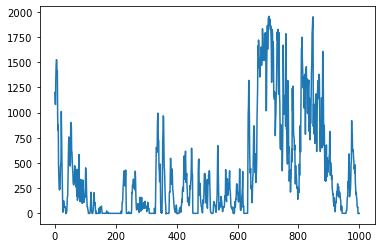

In [15]:
dataset_cp2.loc[:1000,'P_avg'].plot()

In [16]:
dataset_cp2_save = dataset_cp2[['Date_time','P_avg', 'Ws_avg', 'Ot_avg', 'Wa_avg', 'Ya_avg', 'Ba_avg', 'Day sin', 'Day cos', 'Year sin', 'Year cos']].copy()

In [18]:
PATH_TO_DIR = '../datasets/after_imputation'

if not os.path.exists(PATH_TO_DIR):
    os.makedirs(PATH_TO_DIR)
    

PATH_TO_SAVE = os.path.join(PATH_TO_DIR, 'turbine_{}.csv'.format(TURBINE_ID))
dataset_cp2_save.to_csv(PATH_TO_SAVE, sep='\t', index=False, encoding='utf-8')